## 1. Augmentacja

In [148]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

cifar_trainset = CIFAR10(root='./data', train=True, download=False)
data = cifar_trainset.data / 255

mean = data.mean(axis=(0, 1, 2))
std = data.std(axis=(0, 1, 2))

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

## 2, 3 - przypięcie augmentacji, załadowanie cifar-10

In [149]:

train_dataset = CIFAR10(root='./data', train=True,
                        transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=4)

test_dataset = CIFAR10(root='./data', train=False,
                       transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


## 4, 5 - Patching

In [150]:
import torch.nn as nn

def image_to_patches(images, patch_size):
        _, _, height, width = images.size()
        num_patches_h = height // patch_size
        num_patches_w = width // patch_size
        x = images
        x = x.permute(0, 2, 3, 1)
        x = x.view(x.shape[0], num_patches_h, patch_size, num_patches_w, patch_size, x.shape[3])
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        return x
    

In [151]:

data_iter = iter(train_loader)
images, _ = next(data_iter)

In [152]:
patches = image_to_patches(images, 4)


In [153]:
import matplotlib.pyplot as plt
import torch

def plot_patches_grid(patches):
    num_patches_h, num_patches_w, _, _, _ = patches.shape
    
    fig, axes = plt.subplots(num_patches_h, num_patches_w, figsize=(8, 8))
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            patch = patches[i, j]
            patch = (patch * torch.tensor(std) + torch.tensor(mean))
            patch = torch.clamp(patch, 0, 1)
            axes[i, j].imshow(patch.numpy())
            axes[i, j].axis("off")
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


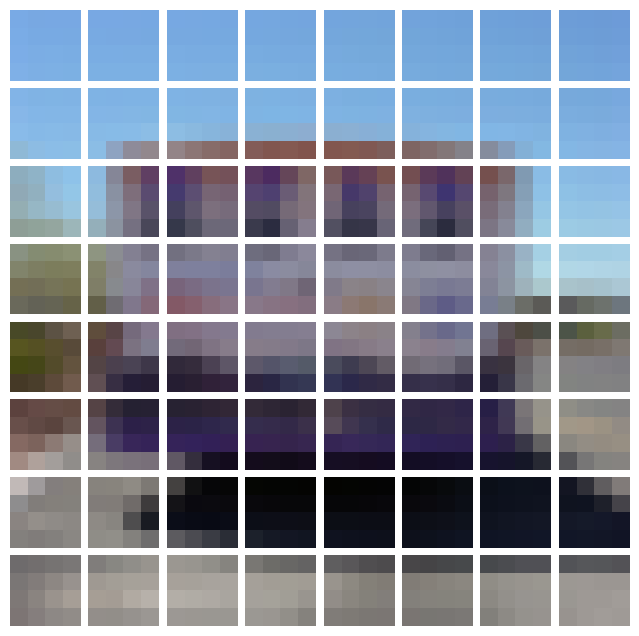

In [154]:
plot_patches_grid(patches[21])

## 6. Model

In [155]:
import torch
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        y = self.norm1(x)
        attn_output, _ = self.attention(y, y, y)
        x = x + attn_output
        
        x = x + self.mlp(x)
        return x


class VisualTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, embed_dim=256, num_classes=10, depth=6, num_heads=8, mlp_dim=512, dropout=0.2):
        super().__init__()
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2

        # Patch Embedding
        self.patch_embedding = nn.Linear(patch_size * patch_size * 3, embed_dim)
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        # Class Token
        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Dropout
        self.embedding_dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.transformers = nn.ModuleList([
            Transformer(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

        # Output layers
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # patch embedding
        x = image_to_patches(x, self.patch_size)
        x = x.view(x.shape[0], -1, self.patch_size * self.patch_size * x.shape[-1])
        embeddings = self.patch_embedding(x)

        # class token and positional embeddings
        cls_token = self.class_token.expand(batch_size, -1, -1)
        embeddings = torch.cat([cls_token, embeddings], dim=1) + self.positional_embedding

        # dropout after embeddings
        embeddings = self.embedding_dropout(embeddings)

        # Pass through Transformer layers
        for transformer in self.transformers:
            embeddings = transformer(embeddings)

        # Classification based on the class token
        cls_output = self.layer_norm(embeddings[:, 0])
        return self.mlp_head(cls_output)


In [156]:
# from torchviz import make_dot

# # Instantiate the model
# model = VisualTransformer(img_size=32, patch_size=4, embed_dim=256, num_classes=10)

# # Dummy input tensor (batch size 1, 3 channels, 32x32 image)
# dummy_input = torch.randn(1, 3, 32, 32)

# # Forward pass and graph visualization
# output = model(dummy_input)
# graph = make_dot(output, params=dict(model.named_parameters()))

# # Save or display the graph
# graph.render("visual_transformer_graph", format="png", cleanup=True)



In [157]:
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02d}h:{minutes:02d}m:{seconds:02d}s"


In [158]:
from torch import inf
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from datetime import datetime

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VisualTransformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.002)
scheduler = MultiStepLR(optimizer, milestones=[30, 52], gamma=0.1)

training_start_time = datetime.now()
save_path = f"./models/vit_{int(training_start_time.timestamp())}.pth"
best_eval_loss = inf
print("epoch,lr,train_loss,test_loss,train_acc,test_acc,epoch_time,total_time")
for epoch in range(60):
    epoch_start_time = datetime.now()
    model.train()
    train_loss, train_correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()


    model.eval()
    test_loss, test_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            
    if(test_loss < best_eval_loss):
        best_eval_loss = test_loss
        torch.save(model.state_dict(), save_path)          

    
    scheduler.step()
    print(f"{epoch},{optimizer.param_groups[0]['lr']:.5f},{train_loss/len(train_loader):.4f},{test_loss/len(test_loader):.4f},{train_correct / len(train_dataset):.4f},{test_correct / len(test_dataset):.4f},{format_timedelta(datetime.now() - epoch_start_time)},{format_timedelta(datetime.now() - training_start_time)}")

epoch,lr,train_loss,test_loss,train_acc,test_acc,epoch_time,total_time


KeyboardInterrupt: 